[**Blueprints for Text Analysis Using Python**](https://github.com/blueprints-for-text-analytics-python/blueprints-text)  
Jens Albrecht, Sidharth Ramachandran, Christian Winkler

**If you like the book or the code examples here, please leave a friendly comment on [Amazon.com](https://www.amazon.com/Blueprints-Text-Analytics-Using-Python/dp/149207408X)!**
<img src="https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/rating.png?raw=1" width="100"/>


# Chapter 4:<div class='tocSkip'/>

# Preparing Textual Data For Statistics and Machine Learning

## Compatibility with spaCy 3.x<div class="tocSkip"/>

We adjusted the this notebook to run with spaCy 3.2 and textacy 0.12.

## Remark<div class='tocSkip'/>

The code in this notebook differs slightly from the printed book. For example we frequently use pretty print (`pp.pprint`) instead of `print` and `tqdm`'s `progress_apply` instead of Pandas' `apply`.

Moreover, several layout and formatting commands, like `figsize` to control figure size or subplot commands are removed in the book.

You may also find some lines marked with three hashes ###. Those are not in the book as well as they don't contribute to the concept.

All of this is done to simplify the code in the book and put the focus on the important parts instead of formatting.

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [ ]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch04/setup.py')


In [7]:
%run -i setup.py

In [9]:
%run -i settings.py

In [ ]:
!python -m spacy download en_core_web_sm

## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [10]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# path to import blueprints packages
sys.path.append(BASE_DIR + '/packages')

## What you'll learn and what we build


# A Data Preprocessing Pipeline


# Introducing the Data Set: Reddit Self Posts


## Loading Data into Pandas


In [11]:
import pandas as pd

posts_file = "rspct.tsv.gz"
posts_file = f"{BASE_DIR}/data/reddit-selfposts/rspct_autos.tsv.gz" ### real location
posts_df = pd.read_csv(posts_file, sep='\t')

subred_file = "subreddit_info.csv.gz"
subred_file = f"{BASE_DIR}/data/reddit-selfposts/subreddit_info.csv.gz" ### real location
subred_df = pd.read_csv(subred_file).set_index(['subreddit'])

df = posts_df.join(subred_df, on='subreddit')
len(df) ###

20000

## Blueprint: Standardizing Attribute Names


In [14]:
print(df.columns)
# print(list(df.columns))

Index(['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2',
       'category_3', 'in_data', 'reason_for_exclusion'],
      dtype='object')


In [15]:
column_mapping = {
    'id': 'id',
    'subreddit': 'subreddit',
    'title': 'title',
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'subcategory',
    'category_3': None, # no data
    'in_data': None, # not needed
    'reason_for_exclusion': None # not needed
}

# define remaining columns
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

# select and rename those columns
df = df[columns].rename(columns=column_mapping)

In [16]:
df = df[df['category'] == 'autos']

In [17]:
len(df)

20000

In [21]:
pd.options.display.max_colwidth = None ###
df.sample(1, random_state=7).T
# pd.options.display.max_colwidth = 200 ###

,14356
id,7jc2k4
subreddit,volt
title,Dashcam for 2017 volt
text,Hello.<lb>I'm looking into getting a dashcam. <lb>Does anyone have any recommendations? <lb><lb>I'm generally looking for a rechargeable one so that I don't have to route wires down to the cigarette lighter. <lb>Unless there are instructions on how to wire it properly without wires showing. <lb><lb><lb>Thanks!
category,autos
subcategory,chevrolet


## Saving and Loading a Data Frame


In [22]:
df.to_pickle("reddit_dataframe.pkl")

In [23]:
import sqlite3

db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
# 使用df的to_sql方法将数据保存到posts数据库中
df.to_sql("posts", con, index=False, if_exists="replace")
con.close()

20000

In [24]:
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts", con)
con.close()

In [25]:
len(df)

20000

# Cleaning Text Data


In [26]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

In [27]:
print(text)


After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>


## Blueprint: Identify Noise with Regular Expressions


In [28]:
import re

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

print(impurity(text))

0.09009009009009009


In [29]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
df['impurity'] = df['text'].progress_apply(impurity, min_len=10)

# get the top 3 records
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)
pd.options.display.max_colwidth = 200 ###

  0%|          | 0/20000 [00:00<?, ?it/s]

,text,impurity
19682,Looking at buying a 335i with 39k miles and 11 months left on the CPO warranty. I asked the deal...,0.21
12357,I'm looking to lease an a4 premium plus automatic with the nav package.<lb><lb>Vehicle Price:<ta...,0.17
2730,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L 4-cylinder<lb><lb>6-speed Manual Transmission<lb>...,0.14


In [33]:
from blueprints.exploration import count_words
count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

  0%|          | 0/20000 [00:00<?, ?it/s]

,freq
token,
<lb>,100729
<tab>,642


## Blueprint: Noise Removal with Regular Expressions


In [35]:
import html

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [36]:
clean_text = clean(text)
print(clean_text)
print("Impurity:", impurity(clean_text))

After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool Captain America
Impurity: 0.0


In [37]:
df['clean_text'] = df['text'].progress_map(clean)
df['impurity']   = df['clean_text'].apply(impurity, min_len=20)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [38]:
df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False) \
                              .head(3)

,clean_text,impurity
14058,"Mustang 2018, 2019, or 2020? Must Haves!! 1. Have a Credit score of 780\+ for the best low interest rates! 2. Join a Credit Union to finance the vehicle! 3. Or Find a Lender to finance the vehicle...",0.03
18934,"At the dealership, they offered an option for foot-well illumination, but I cannot find any reference to this online. Has anyone gotten it? How does it look? Anyone have pictures. Not sure if this...",0.03
16505,"I am looking at four Caymans, all are in a similar price range. The major differences are the miles, the years, and one isn’t a S. https://www.cargurus.com/Cars/inventorylisting/viewDetailsFilterV...",0.02


## Blueprint: Character Normalization with textacy


In [39]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [40]:
import textacy
import textacy.preprocessing as tprep

if textacy.__version__ < '0.11':
    # as in book
    def normalize(text):
        text = tprep.normalize_hyphenated_words(text)
        text = tprep.normalize_quotation_marks(text)
        text = tprep.normalize_unicode(text)
        text = tprep.remove_accents(text)
        return text

else:
    # adjusted to textacy 0.11
    def normalize(text):
        text = tprep.normalize.hyphenated_words(text)
        text = tprep.normalize.quotation_marks(text)
        text = tprep.normalize.unicode(text)
        text = tprep.remove.accents(text)
        return text

In [41]:
print(normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


## Blueprint: Pattern-based Data Masking with textacy


In [43]:
from textacy.preprocessing.resources import RE_URL

print(count_words(df, column='clean_text', preprocess=RE_URL.findall).head(3))

  0%|          | 0/20000 [00:00<?, ?it/s]

                                                                                              freq
token                                                                                             
www.getlowered.com                                                                               3
http://www.ecolamautomotive.com/#!2/kv7fq                                                        2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/     2


In [44]:
if textacy.__version__ < '0.11':
    # as in book
    replace_urls = textacy.preprocessing.replace_urls
else:
    replace_urls = textacy.preprocessing.replace.urls

text = "Check out https://spacy.io/usage/spacy-101"

# using default substitution _URL_
print(replace_urls(text))

Check out _URL_


In [45]:
df['clean_text'] = df['clean_text'].progress_map(replace_urls)
df['clean_text'] = df['clean_text'].progress_map(normalize)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [46]:
df.rename(columns={'text': 'raw_text', 'clean_text': 'text'}, inplace=True)
df.drop(columns=['impurity'], inplace=True)

con = sqlite3.connect(db_name)
df.to_sql("posts_cleaned", con, index=False, if_exists="replace")
con.close()

20000

In [48]:
print(df.head())

       id   subreddit                                     title  \
0  8f73s7      Harley                            No Club Colors   
1  5s0q8r     Mustang                     Roush vs Shleby GT500   
2  5z3405  Volkswagen  2001 Golf Wagon looking for some insight   
3  7df18v       Lexus               IS 250 Coolant Flush/Change   
4  5tpve8        volt                 Gen1 mpg w/ dead battery?   

                                                                                                                                                                                                  raw_text  \
0  Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We alwa...   
1  I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won 2/3). But I was wondering if it was just because of the bigass supercharger

# Tokenization


In [49]:
text = """
2019-08-10 23:32: @pete/@louis - I don't have a well-designed
solution for today's problem. The code of module AC68 should be -1.
Have to think a bit... #goodnight ;-) 😩😬"""

## Blueprint: Tokenization with Regular Expressions


In [50]:
tokens = re.findall(r'\w\w+', text)
print(*tokens, sep='|')

2019|08|10|23|32|pete|louis|don|have|well|designed|solution|for|today|problem|The|code|of|module|AC68|should|be|Have|to|think|bit|goodnight


In [51]:
RE_TOKEN = re.compile(r"""
               ( [#]?[@\w'’\.\-\:]*\w     # words, hash tags and email adresses
               | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
               | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
               )
               """, re.VERBOSE)

def tokenize(text):
    return RE_TOKEN.findall(text)

tokens = tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


## Tokenization with NLTK


In [53]:
import nltk

nltk.download('punkt_tab') ###
tokens = nltk.tokenize.word_tokenize(text)
print(*tokens, sep='|')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|😩😬


In [54]:
# Not in book: Regex Tokenizer
tokenizer = nltk.tokenize.RegexpTokenizer(RE_TOKEN.pattern, flags=re.VERBOSE)
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


In [55]:
# Not in book: Tweet Tokenizer
tokenizer = nltk.tokenize.TweetTokenizer()
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-|10|23:32|:|@pete|/|@louis|-|I|don't|have|a|well-designed|solution|for|today's|problem|.|The|code|of|module|AC68|should|be|-|1|.|Have|to|think|a|bit|...|#goodnight|;-)|😩|😬


In [56]:
# Not in book: Toktok Tokenizer
tokenizer = nltk.tokenize.ToktokTokenizer()
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-10|23|:|32|:|@pete/@louis|-|I|don|'|t|have|a|well-designed|solution|for|today|'|s|problem.|The|code|of|module|AC68|should|be|-1.|Have|to|think|a|bit|...|#goodnight|;|-|)|😩😬


## Recommendations for Tokenization


# Linguistic Processing with spaCy


## Instantiating a Pipeline


In [57]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [58]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7c62291b9f60>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7c62296d0ee0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7c6226342d50>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7c62266877c0>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7c62cd1ae940>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7c62263429d0>)]

In [59]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

## Processing Text


In [60]:
nlp = spacy.load("en_core_web_sm")
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [61]:
for token in doc:
    print(token, end="|")

My|best|friend|Ryan|Peters|likes|fancy|adventure|games|.|

In [62]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  'text': t.text, 'lemma_': t.lemma_,
                   'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 'dep_': t.dep_,
                   'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)

    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [63]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,My,my,True,True,PRON,poss,,O
1,best,good,False,True,ADJ,amod,,O
2,friend,friend,False,True,NOUN,nsubj,,O
3,Ryan,Ryan,False,True,PROPN,compound,PERSON,B
4,Peters,Peters,False,True,PROPN,appos,PERSON,I
5,likes,like,False,True,VERB,ROOT,,O
6,fancy,fancy,False,True,ADJ,amod,,O
7,adventure,adventure,False,True,NOUN,compound,,O
8,games,game,False,True,NOUN,dobj,,O


## Blueprint: Customizing Tokenization


In [64]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) 😋👍"
nlp = spacy.load('en_core_web_sm') ###
doc = nlp(text)

for token in doc:
    print(token, end="|")

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|😋|👍|

In [65]:
import re ###
import spacy ###
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
                       compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):

    # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes
                if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes
                if not re.search(pattern, 'xx-xx')]

    return Tokenizer(vocab          = nlp.vocab,
                     rules          = nlp.Defaults.tokenizer_exceptions,
                     prefix_search  = compile_prefix_regex(prefixes).search,
                     suffix_search  = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match    = nlp.Defaults.token_match)

nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = custom_tokenizer(nlp)

doc = nlp(text)
for token in doc:
    print(token, end="|")

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|😋|👍|

## Blueprint: Working with Stop Words


In [66]:
nlp = spacy.load('en_core_web_sm') ###
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


In [67]:
nlp = spacy.load('en_core_web_sm')
nlp.vocab['down'].is_stop = False
nlp.vocab['Dear'].is_stop = True
nlp.vocab['Regards'].is_stop = True

**Not in book: Modifying stop words with a language subclass**

Modifying the stop word by changing the vocabulary will probably become deprecated with spaCy 3.0. Instead it is recommended to create a subclass of the respective language like this:

In [68]:
# not in book: subclass approach to modify stop word lists
# recommended from spaCy version 3.0 onwards
from spacy.lang.en import English

excluded_stop_words = {'down'}
included_stop_words = {'dear', 'regards'}

class CustomEnglishDefaults(English.Defaults):
    stop_words = English.Defaults.stop_words.copy()
    stop_words -= excluded_stop_words
    stop_words |= included_stop_words

class CustomEnglish(English):
    Defaults = CustomEnglishDefaults

nlp = CustomEnglish()

text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp.make_doc(text) # only tokenize

tokens_wo_stop = [token for token in doc ]
for token in doc:
    if not token.is_stop and not token.is_punct:
        print(token, end='|')

Ryan|need|sit|down|talk|Pete|

In [69]:
# reset nlp to original
nlp = spacy.load('en_core_web_sm')

## Blueprint: Extracting Lemmas based on Part-of-Speech


In [70]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

print(*[t.lemma_ for t in doc], sep='|')

my|good|friend|Ryan|Peters|like|fancy|adventure|game|.


In [71]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[friend, Ryan, Peters, adventure, games]


In [72]:
import textacy

tokens = textacy.extract.words(doc,
            filter_stops = True,           # default True, no stopwords
            filter_punct = True,           # default True, no punctuation
            filter_nums = True,            # default False, no numbers
            include_pos = ['ADJ', 'NOUN'], # default None = include all
            exclude_pos = None,            # default None = exclude none
            min_freq = 1)                  # minimum frequency of words

print(*[t for t in tokens], sep='|')

best|friend|fancy|adventure|games


In [73]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

good|friend|fancy|adventure|game


## Blueprint: Extracting Noun Phrases


In [74]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

patterns = ["POS:ADJ POS:NOUN:+"]

if textacy.__version__ < '0.11':
    # as in book
    spans = textacy.extract.matches(doc, patterns=patterns)
else:
    # new textacy version
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

print(*[s.lemma_ for s in spans], sep='|')

good friend|fancy adventure|fancy adventure game


In [75]:
print(*doc.noun_chunks, sep='|')

My best friend|Ryan Peters|fancy adventure games


In [76]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")

    if textacy.__version__ < '0.11':
        # as in book
        spans = textacy.extract.matches(doc, patterns=patterns)
    else:
        # new textacy version
        spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


## Blueprint: Extracting Named Entities


In [77]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [78]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [79]:
def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc,
             include_types=include_types,
             exclude_types=None,
             drop_determiners=True,
             min_freq=1)

    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [80]:
print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


# Feature Extraction on a Large Dataset


## Blueprint: One Function to Get It All


In [81]:
def extract_nlp(doc):
    return {
    'lemmas'          : extract_lemmas(doc,
                                     exclude_pos = ['PART', 'PUNCT',
                                        'DET', 'PRON', 'SYM', 'SPACE'],
                                     filter_stops = False),
    'adjs_verbs'      : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
    'nouns'           : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'noun_phrases'    : extract_noun_phrases(doc, ['NOUN']),
    'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
    'entities'        : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [82]:
nlp = spacy.load('en_core_web_sm')

In [83]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs: ['good', 'like', 'fancy']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']
noun_phrases: ['adventure_game']
adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities: ['Ryan_Peters/PERSON']


In [84]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


## Blueprint: Using spaCy on a Large Data Set


In [85]:
import sqlite3 ###

db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts_cleaned", con)
con.close()

df['text'] = df['title'] + ': ' + df['text']

In [86]:
for col in nlp_columns:
    df[col] = None

**On Colab**: Choose "Runtime"&rarr;"Change Runtime Type"&rarr;"GPU" to benefit from the GPUs.

In [87]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [88]:
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp) # optional

In [89]:
# full data set takes about 6-8 minutes
# for faster processing use a sample like this
df = df.sample(500)

In [90]:
batch_size = 50
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])

    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

  0%|          | 0/10 [00:00<?, ?it/s]

In [91]:
df[['text', 'lemmas', 'nouns', 'noun_phrases', 'entities']].sample(5)

,text,lemmas,nouns,noun_phrases,entities
13911,"Used 2015 Jetta Sport vs New 2017 Golf Wolfsburg: Hey all, trying to decide between these two cars. Thanks ahead of time for your help. Used 2015 VW Jetta Sport -Automatic -26k miles -Previously a...","[use, 2015, Jetta, Sport, vs, New, 2017, Golf, Wolfsburg, hey, all, try, decide, between, two, car, thank, ahead, of, time, for, help, use, 2015, VW, Jetta, Sport, -Automatic, -26k, mile, -previou...","[Jetta, Sport, New, Golf, Wolfsburg, car, thank, time, help, VW, Jetta, Sport, -Automatic, -26k, mile, car, New, VW, Golf, Wolfsburg, speed, manual, -$19,500, Golf, money, end, budget, salaray, 70...","[-26k_mile, speed_manual, speed_manual_-$19,500, manual_-$19,500, student_loan]","[Jetta_Sport/PERSON, Sport_-Automatic/ORG, Bay_area/LOC]"
13591,5th wheel hitch height: I have a 2017 f350 6.7. It sits high but I'm thinking of lifting the truck 4 inches in the front and leveling it. Then adding 35 inch tires. With this lift will it throw a ...,"[5th, wheel, hitch, height, have, 2017, f350, 6.7, sit, high, but, be, think, of, lift, truck, 4, inch, in, front, and, level, then, add, 35, inch, tire, with, lift, will, throw, 5th, wheel, optio...","[wheel, hitch, height, f350, truck, inch, inch, tire, lift, wheel, option, play, height, trailer, bumper, pull, information, thank]","[wheel_hitch, wheel_hitch_height, hitch_height, inch_tire, wheel_option, bumper_pull]",[]
9054,"Road trip in my '12 is complete! 2 weeks, 2500 miles, no charging, regular fuel, and we both survived!: I just got home yesterday afternoon. The volt was an awesome car for road trip. I was pretty...","[road, trip, in, 12, be, complete, 2, week, 2500, mile, charge, regular, fuel, and, survive, just, get, home, yesterday, afternoon, volt, be, awesome, car, for, road, trip, be, pretty, nervous, ab...","[road, trip, week, mile, fuel, yesterday, afternoon, volt, car, road, trip, spare, flat, mpg, gas, injury, car, dog, mouthful, porcupine, Ontario, turn, signal, rock, gravel, road, wood, night, vo...","[road_trip, yesterday_afternoon, road_trip, turn_signal, gravel_road]",[Ontario/GPE]
11510,Wife stained seat on 2018 CRV.....help: Have a 2 month old 2018 CRV that my wife stained passenger seat with leaky lunchbox. It was a vinegar-based salad dressing. Here is stain: _URL_ I tried cle...,"[wife, stain, seat, on, 2018, CRV, help, have, 2, month, old, 2018, CRV, wife, stain, passenger, seat, with, leaky, lunchbox, be, vinegar-based, salad, dressing, here, be, stain, _URL_, try, clean...","[wife, seat, CRV, help, month, CRV, wife, passenger, seat, lunchbox, salad, dressing, stain, _URL_, bit, detailer, quote, dealership, Chicago, place, detail, stain, interior, seat, carpet, stain]","[passenger_seat, salad_dressing]",[Chicago/GPE]
5643,"Google Assistant on Eonon CA8163R: Hi, I have recently purchased Eono CA8163R for my 2011 Mazda 3 , and i can not seem to get google assistant to work, it simply does not pick up any sound not mat...","[Google, Assistant, on, Eonon, CA8163R, Hi, have, recently, purchase, Eono, CA8163R, for, 2011, Mazda, 3, and, can, seem, get, google, assistant, to, work, simply, do, pick, up, sound, matter, try...","[Google, Assistant, Eonon, CA8163R, Hi, Eono, CA8163R, Mazda, google, assistant, sound, mic, bt, call, issue, advice, PS, BT, google, app, result]",[bt_call],"[Google/ORG, bt/GPE, PS/ORG, BT/ORG]"


  0%|          | 0/500 [00:00<?, ?it/s]

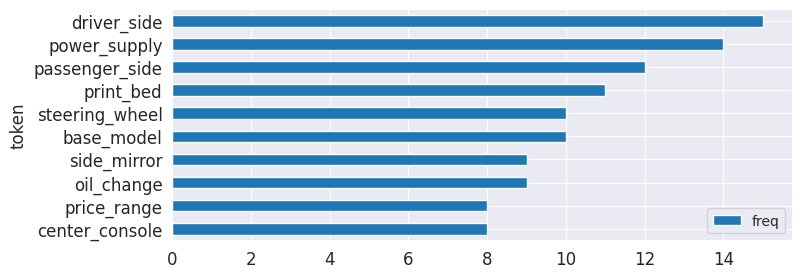

In [92]:
count_words(df, 'noun_phrases').head(10).plot(kind='barh', figsize=(8,3)).invert_yaxis()

## Persisting the Result


In [93]:
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items))

con = sqlite3.connect(db_name)
df.to_sql("posts_nlp", con, index=False, if_exists="replace")
con.close()

500

## A Note on Execution Time


# There is More
## Language Detection


## Additional Blueprint (not in book): Language Detection with fastText

There are different trained models available on the fastText website. We will be using the smaller model `lid.176.ftz` which has a size of less than 1 MB and is almost as accurate as the large model with 126MB. See <https://fasttext.cc/docs/en/language-identification.html> for instructions.

In [94]:
# download model
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

--2024-12-12 15:14:47--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.33, 3.171.22.68, 3.171.22.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: ‘lid.176.ftz’

lid.176.ftz         100%[===================>] 916.03K  --.-KB/s    in 0.06s   

2024-12-12 15:14:47 (15.0 MB/s) - ‘lid.176.ftz’ saved [938013/938013]



In [96]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296186 sha256=dda6f47fca8453dfb810a5086380e64d3051c4bfb792d90da580d9f7f5dcd06f
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


After downloading, we load the model and make a first prediction with the following lines of code:

In [97]:
import fasttext

lang_model = fasttext.load_model("lid.176.ftz")

# make a prediction
print(lang_model.predict('"Good morning" in German is "Guten Morgen"', 3))

(('__label__en', '__label__de', '__label__te'), array([0.97039694, 0.00256404, 0.00231963]))


In [98]:
lang_model.predict('"Good morning" in German is "Guten Morgen"', 3)

(('__label__en', '__label__de', '__label__te'),
 array([0.97039694, 0.00256404, 0.00231963]))

The `predict` function takes a Unicode string as its first argument. The second, optional parameter `k` specifies that we want the `k` language labels with the highest probabilities.

The model returns labels in the form `__label__<code>`, where code is the ISO 639 language code`<footnote>`See <https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes> for a complete list.`</footnote>` and probabilites for each label.

Let's wrap the language identification into a preprocessing function. The function returns the detected language only if the calculated probability is higher than the specified threshold, otherwise, it returns the default language. This is useful for corpora like the hacker news, which is basically an English corpus with some utterances from other languages.

In [99]:
def predict_language(text, threshold=0.8, default='en'):

    # skip language detection for very short texts
    if len(text) < 20:
        return default

    # fasttext requires single line input
    text = text.replace('\n', ' ')

    labels, probas = lang_model.predict(text)
    lang = labels[0].replace("__label__", "")
    proba = probas[0]

    if proba < threshold:
        return default
    else:
        return lang

The prediction function can now easily be applied to a data frame to identify the language of each document.

In [100]:
data = ["I don't like version 2.0 of Chat4you 😡👎",   # English
        "Ich mag Version 2.0 von Chat4you nicht 😡👎", # German
        "Мне не нравится версия 2.0 Chat4you 😡👎",    # Russian
        "Não gosto da versão 2.0 do Chat4you 😡👎",    # Portugese
        "मुझे Chat4you का संस्करण 2.0 पसंद नहीं है 😡👎"]   # Hindi
demo_df = pd.Series(data, name='text').to_frame()

# create new column
demo_df['lang'] = demo_df['text'].apply(predict_language)

demo_df

,text,lang
0,I don't like version 2.0 of Chat4you 😡👎,en
1,Ich mag Version 2.0 von Chat4you nicht 😡👎,de
2,Мне не нравится версия 2.0 Chat4you 😡👎,ru
3,Não gosto da versão 2.0 do Chat4you 😡👎,pt
4,मुझे Chat4you का संस्करण 2.0 पसंद नहीं है 😡👎,hi


In order to get the real names for the language codes, we can provide a mapping dictionary.

In [101]:
url = 'https://raw.githubusercontent.com/haliaeetus/iso-639/master/data/iso_639-1.csv'
lang_df = pd.read_csv(url)
lang_df = lang_df[['name', '639-1', '639-2']].melt(id_vars=['name'], var_name='iso', value_name='code')

# create dictionary with entries {'code': 'name'}
iso639_languages = lang_df.set_index('code')['name'].to_dict()

And we add this to our original data frame:

In [102]:
demo_df['lang_name'] = demo_df['lang'].map(iso639_languages)

demo_df

,text,lang,lang_name
0,I don't like version 2.0 of Chat4you 😡👎,en,English
1,Ich mag Version 2.0 von Chat4you nicht 😡👎,de,German
2,Мне не нравится версия 2.0 Chat4you 😡👎,ru,Russian
3,Não gosto da versão 2.0 do Chat4you 😡👎,pt,Portuguese
4,मुझे Chat4you का संस्करण 2.0 पसंद नहीं है 😡👎,hi,Hindi


## Spell Checking
## Token Normalization


In [103]:
# Not in book: Normalize tokens with a dict
token_map = { 'U.S.': 'United_States',
              'L.A.': 'Los_Angeles' }

def token_normalizer(tokens):
    return [token_map.get(t, t) for t in tokens]

tokens = "L.A. is a city in the U.S.".split()
tokens = token_normalizer(tokens)

print(*tokens, sep='|')

Los_Angeles|is|a|city|in|the|United_States


# Closing Remarks and Recommendations
